In [1]:
import pandas as pd
import numpy as np
import random
from quantnote import BacktestEngine, Strategy

In [66]:
result_df = pd.read_parquet('result.parquet').sort_values('sharpe',ascending=False).reset_index(drop=True)
result_df[result_df.cagr>0.188]

,sharpe,cagr,vol,input1,input2,unary,binary,unary_out
0,1.069502,0.228492,0.213644,pb,fxusd,raw,add,raw
1,0.983807,0.200171,0.203466,debtnc,netincnci,rank,mul,zscore
5,0.916193,0.224250,0.244763,ncf,assetsc,zscore,mul,zscore
9,0.885879,0.192315,0.217089,de,evebit,zscore,sub,zscore
25,0.811159,0.191367,0.235918,evebit,tbvps,zscore,mul,raw


In [61]:
result_df.sharpe.mean()

0.6333740102290499

In [26]:
db_path = '/Users/j.nahmgoong/Documents/git/DB/MainDB.db'

engine = BacktestEngine(db_path)

Loading DB...
DB loaded in 46.23 seconds
[initialize] is executed in 52.93 seconds


In [27]:
engine.show_sample_strategy()

class myStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def compute_target(self, universe_list):
        target_weight = { }
        for ticker in universe_list:
            target_weight[ticker] = 1
        target_weight = self.normalize(target_weight)
        return target_weight

    def custom_factor(self, ticker, ftype):
        if ftype == 'marketcap':
            return self.get_value('metric',ticker,'marketcap')
        else:
            assert False



In [28]:
non_cap_norm = ['tbvps',
'sps',
'ros',
'roe',
'roa',
'ps1',
'ps',
'price',
'prefdivis',
'pe1',
'pe',
'pb',
'payoutratio',
'fcfps',
'epsdil',
'eps',
'dps',
'divyield',
'de',
'currentratio',
'bvps',
'marketcap']

In [29]:
class myStrategy(Strategy):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        print(self.config)

    def compute_target(self, universe_list):
        target_weight = { }
        
        input1 = self.config['input1']
        input2 = self.config['input2']
        unary = self.config['unary']
        binary = self.config['binary']
        unary_out = self.config['unary_out']
        
        factor_series_1 = self.compute_factor_series(universe_list, input1, type=unary)
        factor_series_2 = self.compute_factor_series(universe_list, input2, type=unary)
        
        if binary == 'add':
            factor_series = factor_series_1 + factor_series_2
        elif binary == 'sub':
            factor_series = factor_series_1 - factor_series_2
        elif binary == 'mul':
            factor_series = factor_series_1 * factor_series_2
        elif binary == 'div':
            factor_series = factor_series_1 / factor_series_2
        
        factor_series = factor_series.dropna().sort_values(ascending=False)
        assert len(factor_series) > 0.5*len(universe_list)
        
        if unary_out == 'raw':
            pass
        elif unary_out == 'rank':
            factor_series = factor_series.rank(ascending=False)
        elif unary_out == 'zscore':
            factor_series = (factor_series-factor_series.mean())/factor_series.std()
        
        factor_series = factor_series.dropna().sort_values(ascending=False)
        top = int(len(factor_series.index)/5)
        
        for ticker in factor_series.index:
            weight = factor_series[ticker]
            if weight > 0:
                target_weight[ticker] = weight
            
        target_weight = self.normalize(target_weight)
        return target_weight

    def custom_factor(self, ticker, ftype):
        if ftype == 'marketcap':
            return self.get_value('metric',ticker,'marketcap')
        else:
            if ftype in non_cap_norm:
                x = self.get_value('fundamentals',ticker,ftype)
            else:
                x = self.get_value('fundamentals',ticker,ftype)/self.get_value('fundamentals',ticker,'marketcap')
            return x



In [56]:
result_df.sort_values('cagr',ascending=False).iloc[:10]

,sharpe,cagr,vol,input1,input2,unary,binary,unary_out
0,1.069502,0.228492,0.213644,pb,fxusd,raw,add,raw
1,0.983807,0.200171,0.203466,debtnc,netincnci,rank,mul,zscore
7,0.885879,0.192315,0.217089,de,evebit,zscore,sub,zscore
21,0.811159,0.191367,0.235918,evebit,tbvps,zscore,mul,raw
2,0.979247,0.184406,0.188314,investmentsnc,equity,rank,add,zscore
4,0.945514,0.181857,0.192336,assets,price,rank,sub,zscore
9,0.863566,0.177708,0.205784,sgna,payoutratio,rank,add,zscore
3,0.947315,0.176744,0.186574,debtusd,pe,rank,sub,raw
5,0.904737,0.175577,0.194065,ebitdausd,shareswa,rank,add,zscore
37,0.739949,0.172699,0.233393,eps,assetturnover,rank,div,zscore


{'input1': 'investmentsnc', 'input2': 'equity', 'unary': 'rank', 'binary': 'add', 'unary_out': 'zscore'}
Backtest period: 2016-01-04 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:2.841 / time elapsed:96.1 ===
[run_backtest] is executed in 96.60 seconds


C:\Users\j.nahmgoong\Anaconda3\lib\site-packages\quantnote\backtest_engine.py:350: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


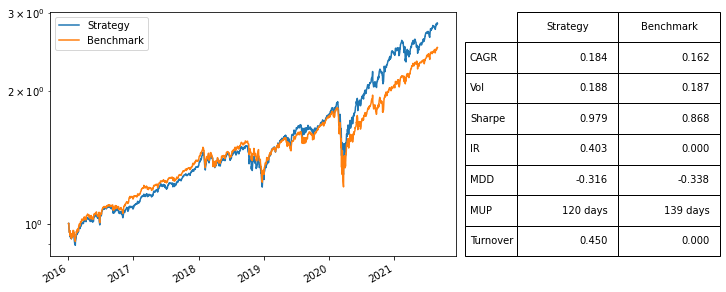

In [52]:
config = {
    'input1':'investmentsnc',
    'input2':'equity',
    'unary':'rank',
    'binary':'add',
    'unary_out':'zscore'}

mys = myStrategy(config)
engine.run_backtest(mys, '2016-01-01','2021-08-31',period='Q')
engine.show_report()

C:\Users\j.nahmgoong\Anaconda3\lib\site-packages\quantnote\backtest_engine.py:456: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


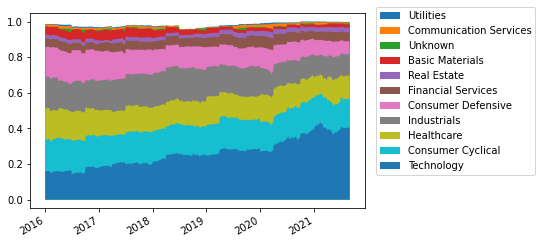

In [53]:
engine.show_sectorflow()